In [ ]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models


import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [ ]:
# Clone tensorflow/examples repo which has images to evaluate trained model
!git clone https://github.com/tensorflow/examples.git

Cloning into 'examples'...
remote: Enumerating objects: 20141, done.
remote: Counting objects: 100% (1961/1961), done.
remote: Compressing objects: 100% (1055/1055), done.
remote: Total 20141 (delta 909), reused 1584 (delta 595), pack-reused 18180
Receiving objects: 100% (20141/20141), 33.15 MiB | 28.67 MiB/s, done.
Resolving deltas: 100% (11003/11003), done.


In [ ]:
# Helper function to download data and extract

def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")

In [ ]:
# Download data and extract it to folder
get_data_extract()

4996292608/4996278331 [==============================] - 195s 0us/step
Dataset downloaded and extracted!


# Understand dataset structure and files 

* The dataset being used is [Food 101](https://www.vision.ee.ethz.ch/datasets_extra/food-101/)
* This dataset has 101000 images in total. It's a food dataset with 101 categories(multiclass)
* Each type of food has 750 training samples and 250 test samples
* Note found on the webpage of the dataset :  
* On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
* The entire dataset is 5GB in size

In [ ]:
# Check the extracted dataset folder
os.listdir('food-101/')

['meta', 'license_agreement.txt', 'README.txt', 'images']

**images** folder contains 101 folders with 1000 images  each  
Each folder contains images of a specific food class

In [ ]:
os.listdir('food-101/images')

['baby_back_ribs',
 'caesar_salad',
 'sushi',
 'beef_carpaccio',
 'tiramisu',
 'crab_cakes',
 'carrot_cake',
 'seaweed_salad',
 'escargots',
 'filet_mignon',
 'omelette',
 'spaghetti_carbonara',
 'shrimp_and_grits',
 'pizza',
 'hamburger',
 'spaghetti_bolognese',
 'nachos',
 'ravioli',
 'breakfast_burrito',
 'bruschetta',
 'french_onion_soup',
 'ceviche',
 'macaroni_and_cheese',
 'dumplings',
 'peking_duck',
 'hummus',
 'chocolate_mousse',
 'cheesecake',
 'red_velvet_cake',
 'bread_pudding',
 'baklava',
 'paella',
 'mussels',
 'bibimbap',
 'strawberry_shortcake',
 'pad_thai',
 'sashimi',
 'garlic_bread',
 'donuts',
 'samosa',
 'takoyaki',
 'waffles',
 'falafel',
 'deviled_eggs',
 'risotto',
 'foie_gras',
 'chicken_wings',
 'fried_calamari',
 'huevos_rancheros',
 'guacamole',
 'croque_madame',
 'beignets',
 'oysters',
 'ice_cream',
 'french_toast',
 'cup_cakes',
 'cheese_plate',
 'poutine',
 'lasagna',
 'chicken_quesadilla',
 'hot_dog',
 'club_sandwich',
 'caprese_salad',
 'beef_tartare

**meta** folder contains the text files - train.txt and test.txt  
**train.txt** contains the list of images that belong to training set  
**test.txt** contains the list of images that belong to test set  
**classes.txt** contains the list of all classes of food

In [ ]:
os.listdir('food-101/meta')

['train.txt',
 'train.json',
 'classes.txt',
 'test.json',
 'test.txt',
 'labels.txt']

# Visualize random image from each of the 101 classes

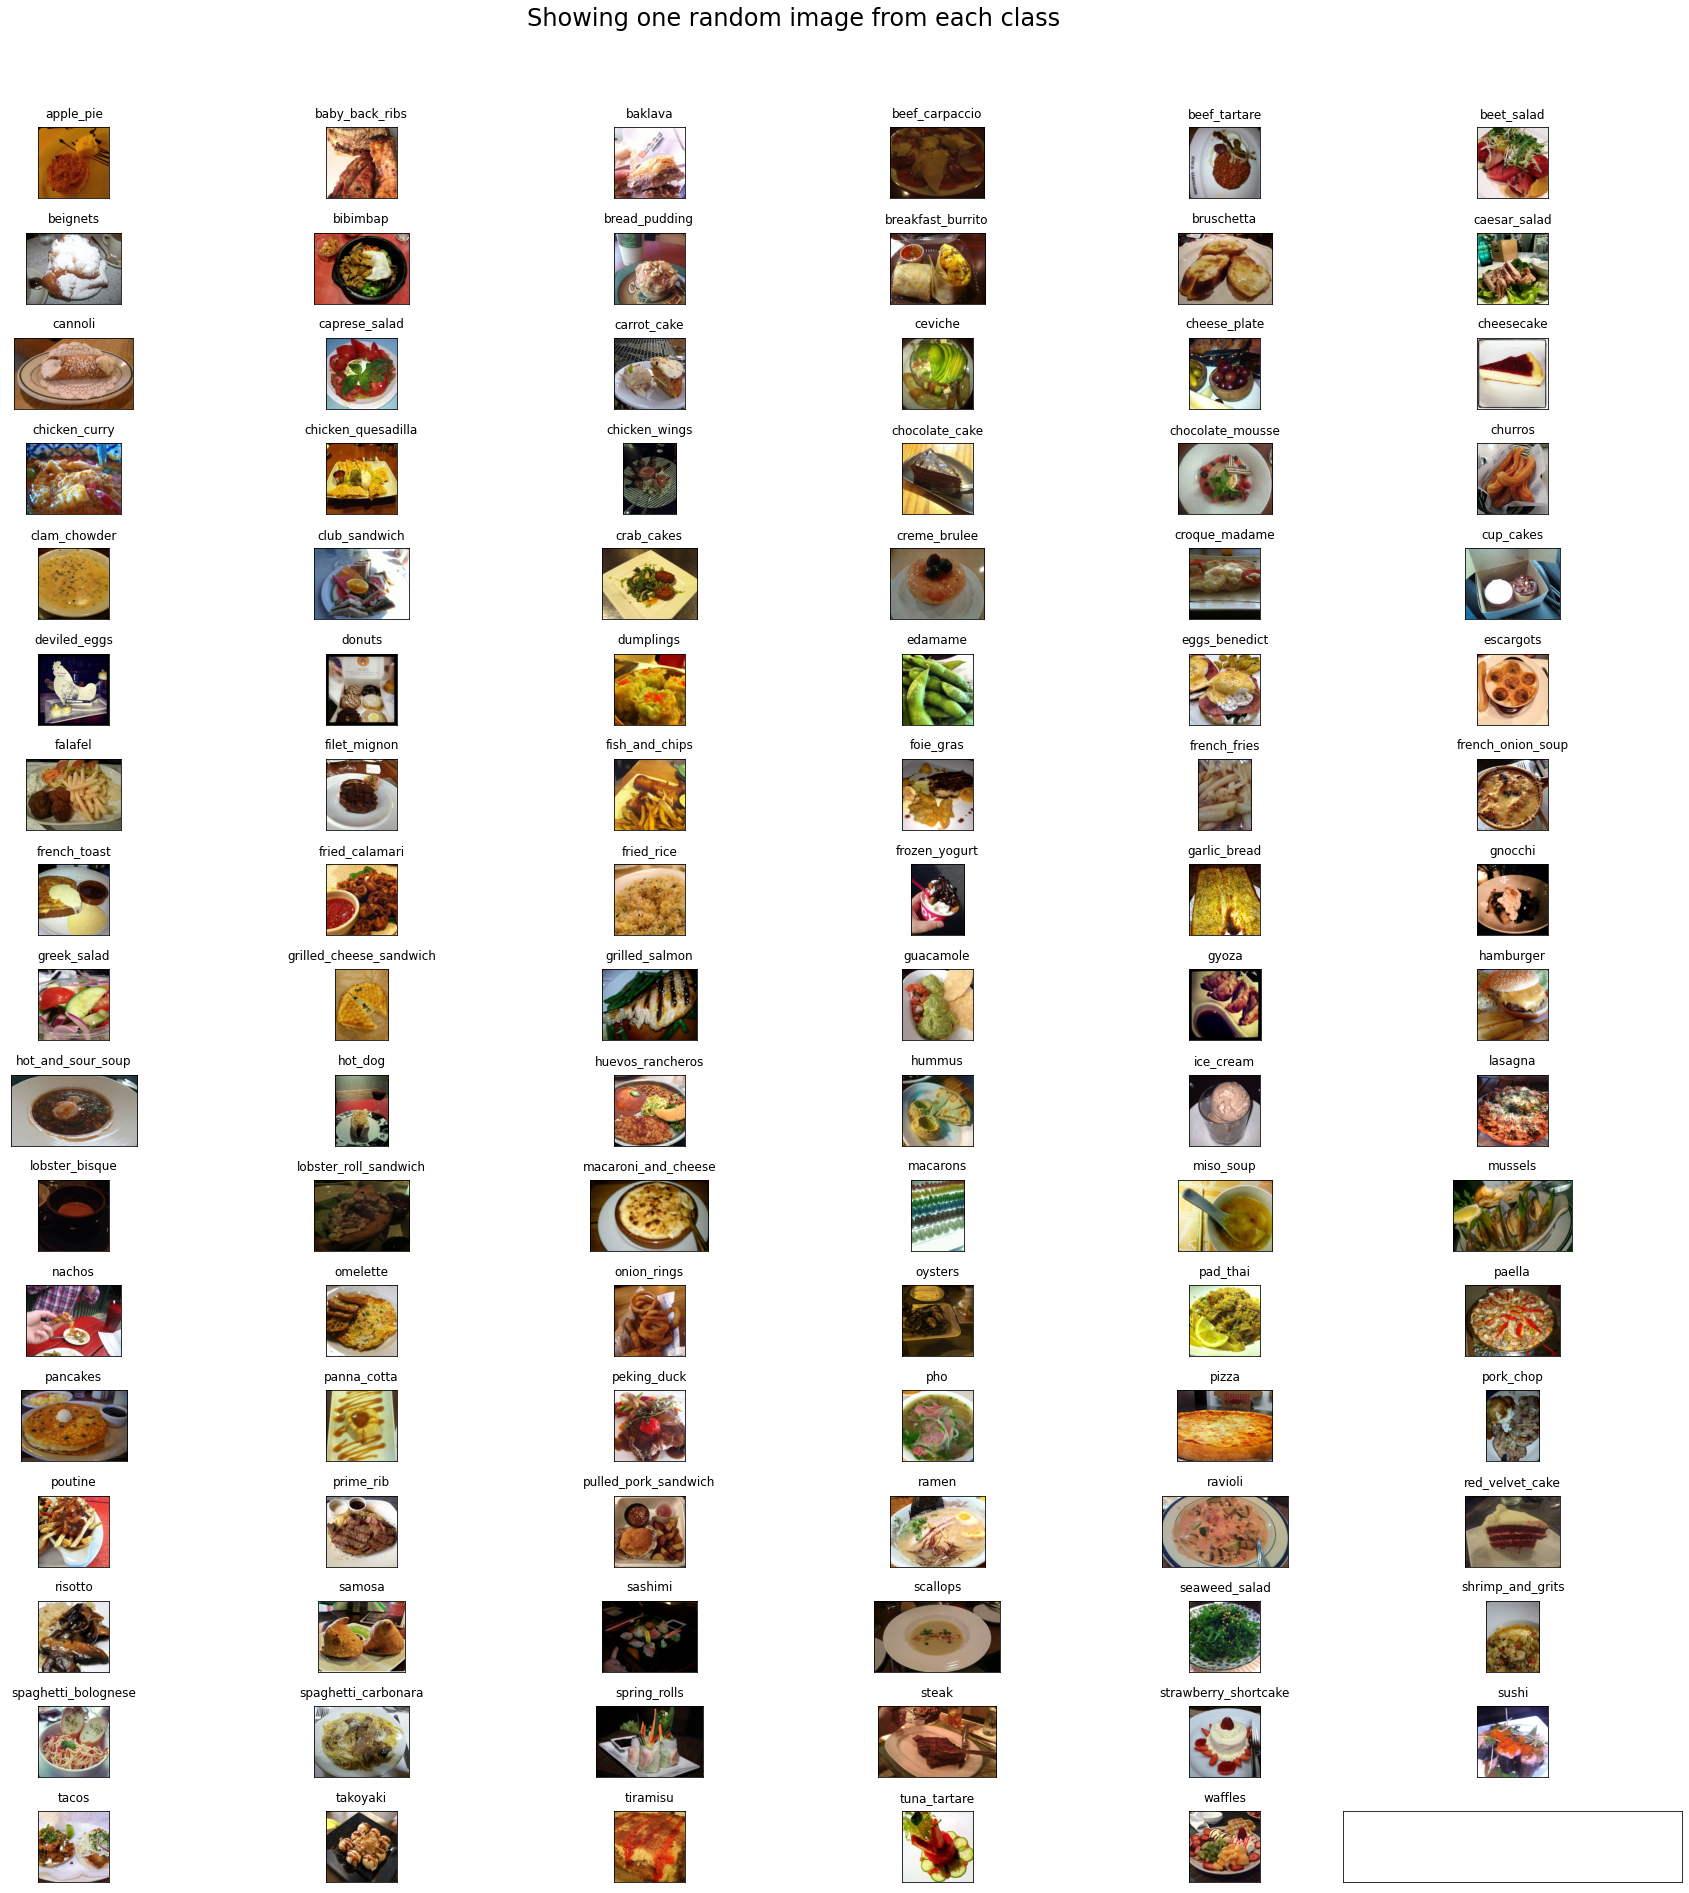

In [ ]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


# Split the image data into train and test using train.txt and test.txt

In [ ]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [ ]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [ ]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [ ]:
# Check how many files are in the train folder

train_files = sum([len(files) for i, j, files in os.walk("food-101/train")])
print("Total number of samples in train folder")
print(train_files)

Total number of samples in train folder
75750


In [ ]:
# Check how many files are in the test folder
test_files = sum([len(files) for i, j, files in os.walk("food-101/test")])
print("Total number of samples in test folder")
print(test_files)

Total number of samples in test folder
25250


# Create a subset of data with few classes (10)

* We now have train and test data ready  
* But to experiment and try different architectures, working on the whole data with 101 classes takes a lot of time and computation  
* To proceed with further experiments, I am creating train_min and test_mini, limiting the dataset to 10 classes  

In [ ]:
# List of all 101 types of foods(sorted alphabetically)
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [ ]:
# picking 3 food items and generating separate data folders for the same
food_list = ['deviled_eggs','beef_tartare','hot_dog','lobster_bisque','sushi','tuna_tartare','fried_rice','samosa','pizza','omelette']
src_train = 'food-101/train'
dest_train = 'food-101/train_mini'
src_test = 'food-101/test'
dest_test = 'food-101/test_mini'

In [ ]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into deviled_eggs
Copying images into beef_tartare
Copying images into hot_dog
Copying images into lobster_bisque
Copying images into sushi
Copying images into tuna_tartare
Copying images into fried_rice
Copying images into samosa
Copying images into pizza
Copying images into omelette


In [ ]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("food-101/train_mini")])
print(train_files)

Total number of samples in train folder
7500


In [ ]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into deviled_eggs
Copying images into beef_tartare
Copying images into hot_dog
Copying images into lobster_bisque
Copying images into sushi
Copying images into tuna_tartare
Copying images into fried_rice
Copying images into samosa
Copying images into pizza
Copying images into omelette


In [ ]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("food-101/test_mini")])
print(test_files)

Total number of samples in test folder
2500


In [ ]:
def train_model(n_classes,num_epochs, nb_train_samples,nb_validation_samples):
  K.clear_session()

  img_width, img_height = 128, 128
  train_data_dir = 'food-101/train_mini'
  validation_data_dir = 'food-101/test_mini'
  batch_size = 16
  bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
  trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
  history_path = 'history_'+str(n_classes)+'.log'

  train_datagen = ImageDataGenerator(
      preprocessing_function=None,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=None)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')
  
  model = tf.keras.Sequential(
    [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, (3,3), padding='valid', activation="relu",input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(32, (3,3), padding='valid', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    Dropout(0.1),

    tf.keras.layers.Conv2D(32, (3,3), padding='valid', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    Dropout(0.1),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation="softmax")
    ]
  )
  
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  from tensorflow.keras.callbacks import EarlyStopping
  callbacks = [
              EarlyStopping(patience=2)
  ]

  checkpoint_filepath = '/tmp/checkpoint'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=False,
      monitor='loss',
      mode='min',
      save_best_only=True)

  callbacks = [
              EarlyStopping(patience=2),
              model_checkpoint_callback,
  ]

  #another_saved_model = tf.keras.models.load_model(checkpoint_filepath)

  #history = model.fit(X_train,y_train, epochs=600,validation_data=(X_test,y_test),callbacks=callbacks)

  history = model.fit(train_generator,
                      steps_per_epoch = nb_train_samples // batch_size,
                      validation_data=validation_generator,
                      validation_steps=nb_validation_samples // batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=callbacks)

  model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  return history, class_map

  

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 20
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_10 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_10)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/20
468/468 [==============================] - 214s 454ms/step - loss: 2.2018 - accuracy: 0.1899 - val_loss: 2.0235 - val_accuracy: 0.2925
Epoch 2/20
468/468 [==============================] - 209s 446ms/step - loss: 2.0000 - accuracy: 0.2819 - val_loss: 1.8815 - val_accuracy: 0.3305
Epoch 3/20
468/468 [==============================] - 233s 499ms/step - loss: 1.8608 - accuracy: 0.3419 - val_loss: 1.7142 - val_accuracy: 0.3862
Epoch 4/20
468/468 [==============================] - 208s 445ms/step - loss: 1.7616 - accuracy: 0.3850 - val_loss: 1.5724 - val_accuracy: 0.4663
Epoch 5/20
468/468 [==============================] - 208s 444ms/step - loss: 1.6726 - accuracy: 0.4113 - val_loss: 1.5477 - val_accuracy: 0.4615
Epoch 6/20
468/468 [==============================] - 208s 445ms/step - loss: 1.6102 - accuracy: 0.4320 - val_loss: 1.5494 - val_accuracy: 0.4391
Epoch 7/20
468/468 [==================

# Visualize the accuracy and loss plots

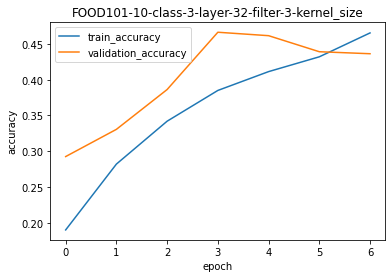

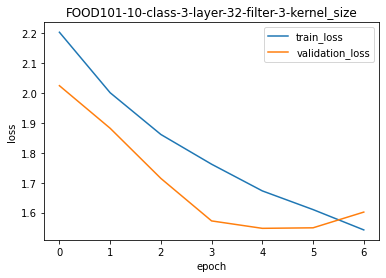

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD101-10-class-3-layer-32-filter-3-kernel_size')
plot_loss(history,'FOOD101-10-class-3-layer-32-filter-3-kernel_size')

In [ ]:
def train_model_v2(n_pairs,n_filters,kernel_size,n_classes,num_epochs, nb_train_samples,nb_validation_samples):
  K.clear_session()

  img_width, img_height = 128, 128
  train_data_dir = 'food-101/train_mini'
  validation_data_dir = 'food-101/test_mini'
  batch_size = 16
  bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
  trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
  history_path = 'history_'+str(n_classes)+'.log'

  train_datagen = ImageDataGenerator(
      preprocessing_function=None,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=None)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')
  
  model = tf.keras.Sequential(
    [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(n_filters, (kernel_size,kernel_size), padding='valid', activation="relu",input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    ]
  )
  for i in range(n_pairs-1):
    model.add(tf.keras.layers.Conv2D(n_filters, (kernel_size,kernel_size), padding='valid', activation="relu"))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(Dropout(0.1))

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(100, activation="relu"))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(10, activation="softmax"))
    
  
  
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  from tensorflow.keras.callbacks import EarlyStopping
  callbacks = [
              EarlyStopping(patience=2)
  ]

  checkpoint_filepath = '/tmp/checkpoint'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=False,
      monitor='loss',
      mode='min',
      save_best_only=True)

  callbacks = [
              EarlyStopping(patience=2),
              model_checkpoint_callback,
  ]


  history = model.fit(train_generator,
                      steps_per_epoch = nb_train_samples // batch_size,
                      validation_data=validation_generator,
                      validation_steps=nb_validation_samples // batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=callbacks)

  model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  return history, class_map

  

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 20
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 4
n_filters = 32
kernel_size = 3
history, class_map_10 = train_model_v2(n_pairs,n_filters,kernel_size,n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_10)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/20
468/468 [==============================] - 217s 462ms/step - loss: 2.2445 - accuracy: 0.1622 - val_loss: 2.1955 - val_accuracy: 0.1843
Epoch 2/20
468/468 [==============================] - 214s 457ms/step - loss: 2.1179 - accuracy: 0.2237 - val_loss: 1.9745 - val_accuracy: 0.2845
Epoch 3/20
468/468 [==============================] - 217s 464ms/step - loss: 2.0325 - accuracy: 0.2660 - val_loss: 1.9089 - val_accuracy: 0.3093
Epoch 4/20
468/468 [==============================] - 217s 463ms/step - loss: 1.9431 - accuracy: 0.3101 - val_loss: 1.8585 - val_accuracy: 0.3345
Epoch 5/20
468/468 [==============================] - 218s 465ms/step - loss: 1.8776 - accuracy: 0.3347 - val_loss: 1.7305 - val_accuracy: 0.3954
Epoch 6/20
468/468 [==============================] - 218s 465ms/step - loss: 1.7988 - accuracy: 0.3582 - val_loss: 1.6422 - val_accuracy: 0.4303
Epoch 7/20
468/468 [==================

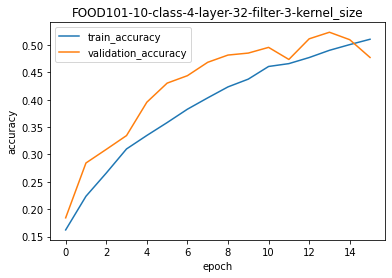

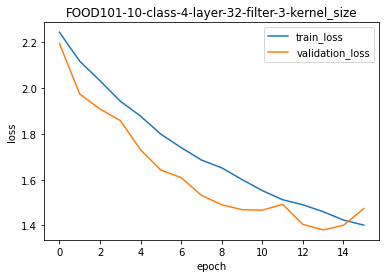

In [ ]:
plot_accuracy(history,'FOOD101-10-class-4-layer-32-filter-3-kernel_size')
plot_loss(history,'FOOD101-10-class-4-layer-32-filter-3-kernel_size')

## **5 pairs 32 filters kernel_size 3**

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 20
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 5
n_filters = 32
kernel_size = 3
history, class_map_10 = train_model_v2(n_pairs,n_filters,kernel_size,n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_10)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/20
468/468 [==============================] - 79s 164ms/step - loss: 2.2952 - accuracy: 0.1191 - val_loss: 2.2754 - val_accuracy: 0.1410
Epoch 2/20
468/468 [==============================] - 86s 184ms/step - loss: 2.2548 - accuracy: 0.1563 - val_loss: 2.1913 - val_accuracy: 0.2039
Epoch 3/20
468/468 [==============================] - 87s 186ms/step - loss: 2.1600 - accuracy: 0.2194 - val_loss: 1.9576 - val_accuracy: 0.3129
Epoch 4/20
468/468 [==============================] - 77s 165ms/step - loss: 2.0279 - accuracy: 0.2757 - val_loss: 1.8599 - val_accuracy: 0.3201
Epoch 5/20
468/468 [==============================] - 76s 163ms/step - loss: 1.9358 - accuracy: 0.3155 - val_loss: 1.7477 - val_accuracy: 0.3822
Epoch 6/20
468/468 [==============================] - 77s 165ms/step - loss: 1.8706 - accuracy: 0.3303 - val_loss: 1.7631 - val_accuracy: 0.3778
Epoch 7/20
468/468 [========================

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()

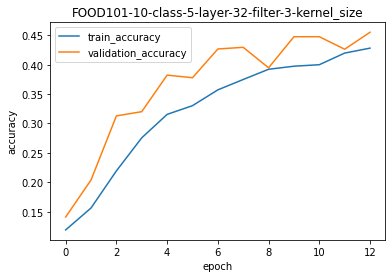

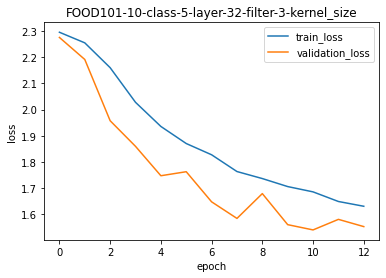

In [ ]:
plot_accuracy(history,'FOOD101-10-class-5-layer-32-filter-3-kernel_size')
plot_loss(history,'FOOD101-10-class-5-layer-32-filter-3-kernel_size')

## **6 pairs 32 filters kernel_size 3**

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 20
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 6
n_filters = 32
kernel_size = 3
history, class_map_10 = train_model_v2(n_pairs,n_filters,kernel_size,n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_10)

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.
Epoch 1/20


In [ ]:
plot_accuracy(history,'FOOD101-10-class-6-layer-32-filter-3-kernel_size')
plot_loss(history,'FOOD101-10-class-6-layer-32-filter-3-kernel_size')

## **7 pairs 32 filters kernel_size 3**

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 20
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 7
n_filters = 32
kernel_size = 3
history, class_map_10 = train_model_v2(n_pairs,n_filters,kernel_size,n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_10)

In [ ]:
plot_accuracy(history,'FOOD101-10-class-7-layer-32-filter-3-kernel_size')
plot_loss(history,'FOOD101-10-class-7-layer-32-filter-3-kernel_size')

## **8 pairs 32 filters kernel_size 3**

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 20
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 8
n_filters = 32
kernel_size = 3
history, class_map_10 = train_model_v2(n_pairs,n_filters,kernel_size,n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_10)

In [ ]:
plot_accuracy(history,'FOOD101-10-class-8-layer-32-filter-3-kernel_size')
plot_loss(history,'FOOD101-10-class-8-layer-32-filter-3-kernel_size')

## **9 pairs 32 filters kernel_size 3**

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 20
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 9
n_filters = 32
kernel_size = 3
history, class_map_10 = train_model_v2(n_pairs,n_filters,kernel_size,n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_10)

In [ ]:
plot_accuracy(history,'FOOD101-10-class-9-layer-32-filter-3-kernel_size')
plot_loss(history,'FOOD101-10-class-9-layer-32-filter-3-kernel_size')

## **10 pairs 32 filters kernel_size 3**

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 20
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 10
n_filters = 32
kernel_size = 3
history, class_map_10 = train_model_v2(n_pairs,n_filters,kernel_size,n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_10)

In [ ]:
plot_accuracy(history,'FOOD101-10-class-10-layer-32-filter-3-kernel_size')
plot_loss(history,'FOOD101-10-class-10-layer-32-filter-3-kernel_size')

## **11 pairs 32 filters kernel_size 3**

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 20
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 11
n_filters = 32
kernel_size = 3
history, class_map_10 = train_model_v2(n_pairs,n_filters,kernel_size,n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_10)

In [ ]:
plot_accuracy(history,'FOOD101-10-class-11-layer-32-filter-3-kernel_size')
plot_loss(history,'FOOD101-10-class-11-layer-32-filter-3-kernel_size')

## **12 pairs 32 filters kernel_size 3**

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 20
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 12
n_filters = 32
kernel_size = 3
history, class_map_10 = train_model_v2(n_pairs,n_filters,kernel_size,n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_10)

In [ ]:
plot_accuracy(history,'FOOD101-10-class-12-layer-32-filter-3-kernel_size')
plot_loss(history,'FOOD101-10-class-12-layer-32-filter-3-kernel_size')

## **13 pairs 32 filters kernel_size 3**

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 20
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 13
n_filters = 32
kernel_size = 3
history, class_map_10 = train_model_v2(n_pairs,n_filters,kernel_size,n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_10)

In [ ]:
plot_accuracy(history,'FOOD101-10-class-13-layer-32-filter-3-kernel_size')
plot_loss(history,'FOOD101-10-class-13-layer-32-filter-3-kernel_size')

## **14 pairs 32 filters kernel_size 3**

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 20
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 14
n_filters = 32
kernel_size = 3
history, class_map_10 = train_model_v2(n_pairs,n_filters,kernel_size,n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_10)

In [ ]:
plot_accuracy(history,'FOOD101-10-class-14-layer-32-filter-3-kernel_size')
plot_loss(history,'FOOD101-10-class-14-layer-32-filter-3-kernel_size')

## **15 pairs 32 filters kernel_size 3**

In [ ]:
# Train the model with data from 10 classes
n_classes = 10
epochs = 20
nb_train_samples = train_files
nb_validation_samples = test_files
n_pairs = 15
n_filters = 32
kernel_size = 3
history, class_map_10 = train_model_v2(n_pairs,n_filters,kernel_size,n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_10)

In [ ]:
plot_accuracy(history,'FOOD101-10-class-15-layer-32-filter-3-kernel_size')
plot_loss(history,'FOOD101-10-class-15-layer-32-filter-3-kernel_size')